# VGAEのデモンストレーション
- VGAEを活用
    - エンコーダー: GCN
    - デコーダー: InnerDecoder
- Coraネットワークを利用してネットワークを生成する


GPU PyTorchの動作確認

In [1]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Aug 19 2025, 12:03:11) [GCC 11.4.0]
PyTorch：2.8.0+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [63]:
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import RandomLinkSplit

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None

# エッジをトレーニング、検証、テストセットに分割
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

# データセットの情報を表示
print(f"TRAIN      node num: {train_data.x.size(0)}, edge num: {train_data.edge_index.size(1)}, node feature num: {train_data.num_node_features}")
print(f"VALIDATION node num: {val_data.x.size(0)}, edge num: {val_data.edge_index.size(1)}, node feature num: {val_data.num_node_features}")
print(f"TEST       node num: {test_data.x.size(0)}, edge num: {test_data.edge_index.size(1)}, node feature num: {test_data.num_node_features}")

TRAIN      node num: 2708, edge num: 8448, node feature num: 1433
VALIDATION node num: 2708, edge num: 8448, node feature num: 1433
TEST       node num: 2708, edge num: 9502, node feature num: 1433


### データを可視化

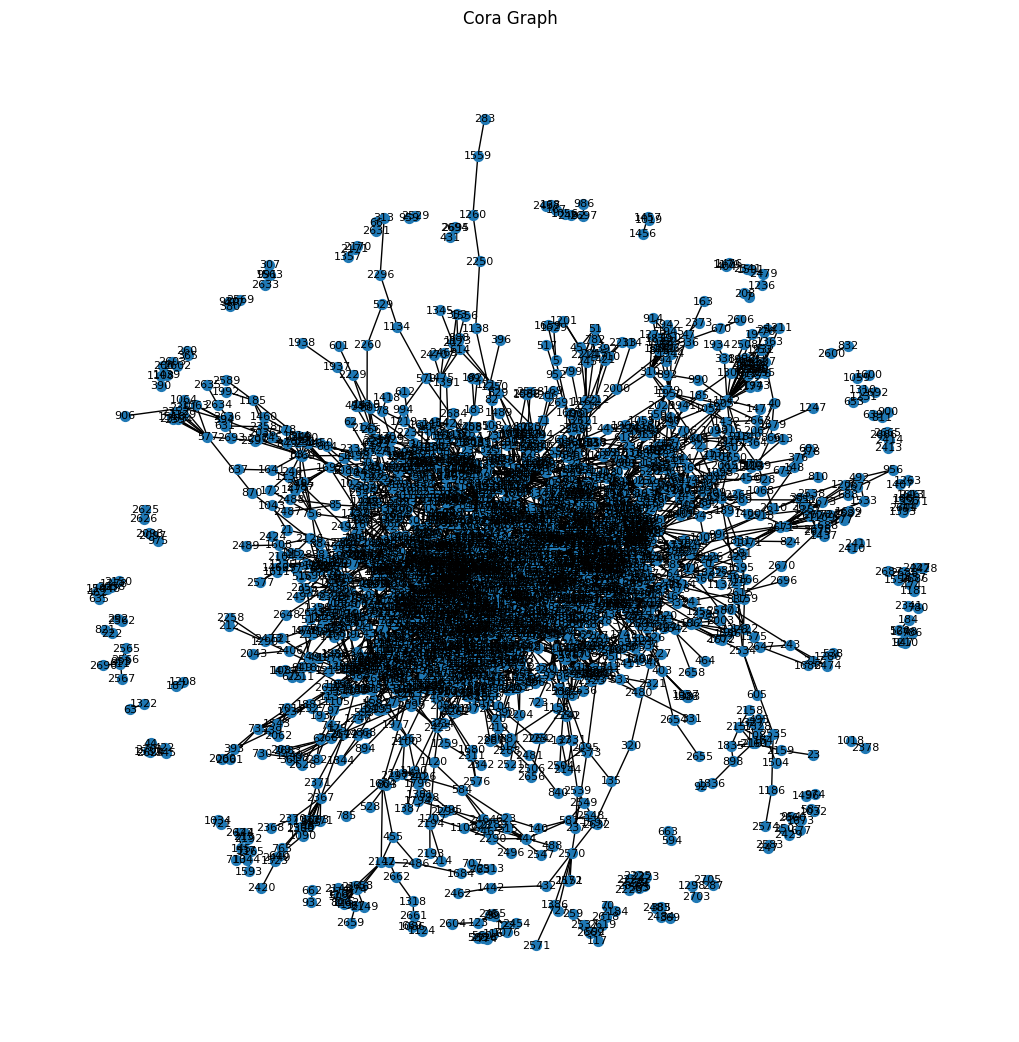

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(train_data.edge_index.t().tolist())

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph")
plt.show()

## VGANを活用したグラフ生成

- Variational Graph Auto-encoder
- 既存のグラフを学習し新たなグラフを生成する

### VGAEモデルの定義

- Graph Encoder: Graph Convolution Network(GCN)
- Graph Decoder: InnerDecoder


In [5]:
from torch_geometric.nn import GCNConv, VGAE

# Encoderの定義
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [ ]:
# モデルの設定
in_channels = train_data.x.size(-1) # 入力される特徴量の次元
out_channels = 3 # 出力される特徴量の次元
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")
model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels)) # エンコーダとデコーダーを合わせてモデルのインスタンス化
print(model)

# モデルとデータをデバイスに転送
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

入力特徴量の次元: 1433, 出力特徴量の次元: 3
VGAE(
  (encoder): GraphEncoder(
    (conv1): GCNConv(1433, 6)
    (conv_mu): GCNConv(6, 3)
    (conv_logstd): GCNConv(6, 3)
  )
  (decoder): InnerProductDecoder()
)


### モデルの学習
- パラメータの更新: Adam
- 目的関数
    - 再構成誤差: recon_loss
    - KLダイバージェンス: KL_loss

In [11]:
# 学習回数と最適化手法の設定
epoch_num = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# モデルの学習
model.train()
for epoch in range(1, epoch_num + 1):
    # 勾配の初期化
    optimizer.zero_grad()

    # モデルの出力
    z = model.encode(train_data.x, train_data.edge_index)

    # 損失の計算
    recon_loss = model.recon_loss(z, train_data.edge_index) # 再構成誤差
    kl_loss = (1 / train_data.num_nodes) * model.kl_loss() # KLダイバージェンス
    loss = recon_loss + kl_loss # 全体の損失

    # パラメータの更新
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 10, Loss: 1.0064401626586914
Epoch 20, Loss: 0.9888802170753479
Epoch 30, Loss: 0.9825581908226013
Epoch 40, Loss: 0.9665895104408264
Epoch 50, Loss: 0.9716166257858276
Epoch 60, Loss: 0.9684082865715027
Epoch 70, Loss: 0.9696008563041687
Epoch 80, Loss: 0.9711951017379761
Epoch 90, Loss: 0.9588252305984497
Epoch 100, Loss: 0.9613503813743591


### モデルの評価
- 2値分類としてネットワーク生成を評価する

**2値分類のネットワーク生成**
- ノードに対してエッジが接続される確率とエッジが接続されない確率の2値をを予測する
- 正負のエッジ
    - 正のエッジ: エッジが接続されるい確率
    - 負のエッジ: エッジが接続されない確率

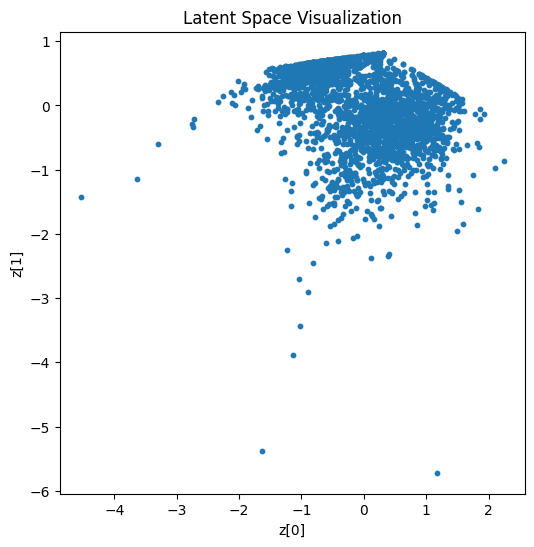

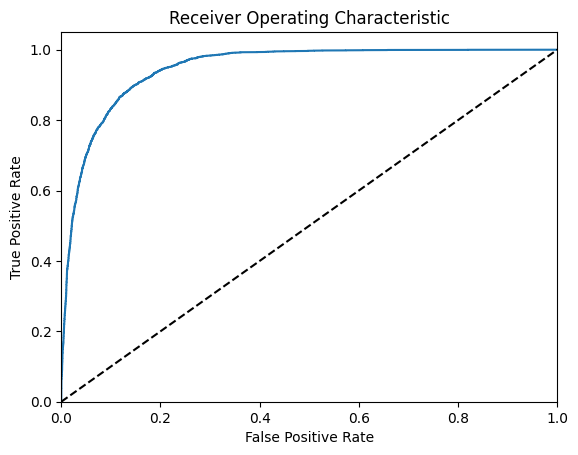

AUC Score: 0.9473
Accuracy: 0.8759
Optimal Threshold: 0.7266
Positive edge predictions (mean): 0.8655
Negative edge predictions (mean): 0.5000


In [60]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve

# ネットワークの生成
model.eval()
with torch.no_grad():
    z = model.encode(val_data.x, val_data.edge_index)
    
    # 潜在ベクトルzの可視化
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
    plt.title("Latent Space Visualization")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # 潜在ベクトルzをデコードしてエッジの存在確率を予測
    x = model.decode(z, val_data.edge_index)

    # 正エッジを予測
    num_pos_edges = val_data.edge_index.size(1)
    pos_edge_index = val_data.edge_index[:, :num_pos_edges]
    pos_pred = model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    num_neg_edges = val_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=val_data.edge_index, 
        num_nodes=val_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax() 
    optimal_threshold = thresholds[optimal_idx]

    # 最適な閾値を用いてAccuracyの計算
    binary_preds = (preds >= optimal_threshold).float()
    accuracy = accuracy_score(labels, binary_preds)

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # AUCスコアと分類精度を表示
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

**テストデータ**

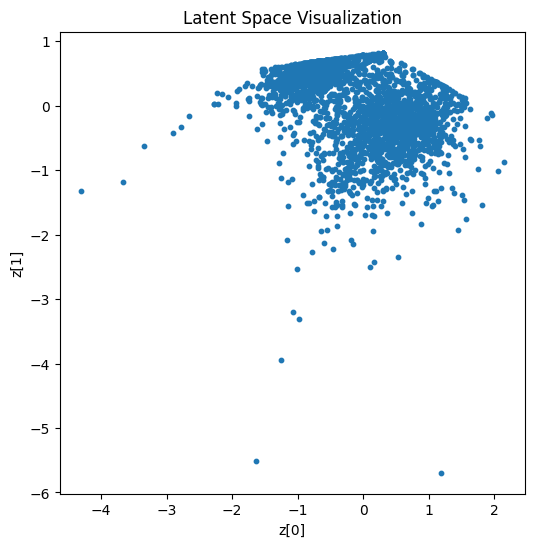

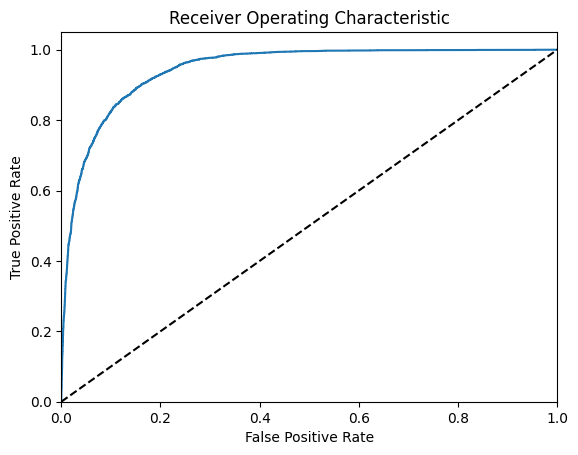

AUC Score: 0.9449
Accuracy: 0.8701
Optimal Threshold: 0.7020
Positive edge predictions (mean): 0.8551
Negative edge predictions (mean): 0.4978


In [59]:
# ネットワークの生成
model.eval()
with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)

    # 潜在ベクトルzの可視化
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
    plt.title("Latent Space Visualization")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # 潜在ベクトルzをデコードして隣接行列を生成
    x = model.decode(z, test_data.edge_index)

    # 正エッジを予測
    num_pos_edges = test_data.edge_index.size(1)
    pos_edge_index = test_data.edge_index[:, :num_pos_edges]
    pos_pred = model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    num_neg_edges = test_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index, 
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax() 
    optimal_threshold = thresholds[optimal_idx]

    # 最適な閾値を用いてAccuracyの計算
    binary_preds = (preds >= optimal_threshold).float()
    accuracy = accuracy_score(labels, binary_preds)

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # AUCスコアと分類精度を表示
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### ネットワークの生成
- 学習したモデルを用いてネットワークを生成する
- 生成したネットワークの可視化

In [61]:
# ネットワークの生成
model.eval()
with torch.no_grad():
    # モデルから潜在ベクトルを出力
    z = model.encode(val_data.x, val_data.edge_index)

    # 予測スコアの計算
    num_pos_edges = test_data.edge_index.size(1)
    pos_edge_index = test_data.edge_index[:, :num_pos_edges]
    pos_pred = model.decode(z, pos_edge_index).view(-1).cpu()
    num_neg_edges = test_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index, 
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = model.decode(z, neg_edge_index).view(-1).cpu()
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # 最適な閾値を決定
    fpr, tpr, thresholds = roc_curve(labels, preds)
    optimal_idx = (tpr - fpr).argmax() 
    optimal_threshold = thresholds[optimal_idx]

    # 潜在ベクトルzをデコードして隣接行列を生成
    prob = torch.sigmoid(z @ z.t())  # xとzの内積を計算して接続確率を算出
    adj_matrix = (prob > optimal_threshold).nonzero(as_tuple=False).t() # 二値化して隣接行列を生成
    adj_matrix = adj_matrix[:, torch.randperm(adj_matrix.size(1))[:val_data.num_edges]] # エッジをサンプリング

**生成したネットワークの可視化**

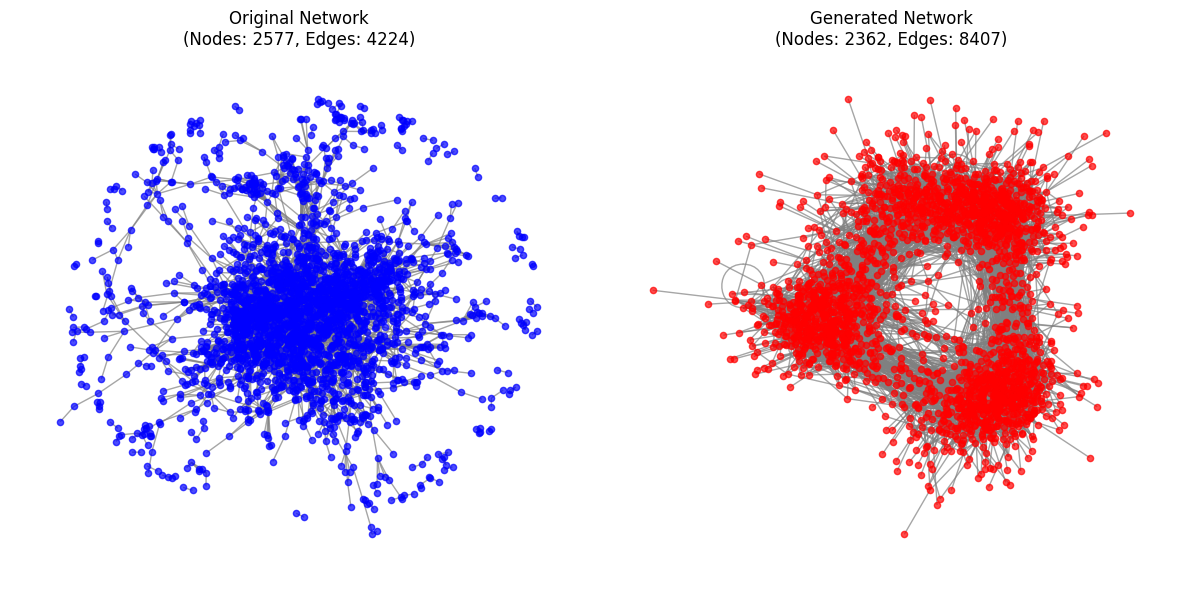

=== Network Statistics Comparison ===
Original Network  - Nodes: 2577, Edges: 4224
Generated Network - Nodes: 2362, Edges: 8407
Original avg degree: 3.28
Generated avg degree: 7.12


In [62]:
G_generated = nx.Graph()

# adj_matrixから生成されたエッジを追加
edges = adj_matrix.t().cpu().numpy()
G_generated.add_edges_from(edges)

# 生成されたネットワークの可視化
plt.figure(figsize=(12, 6))

# 元のネットワークと生成されたネットワークを比較表示
plt.subplot(1, 2, 1)
pos_original = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos_original, with_labels=False, node_size=20, node_color='blue', edge_color='gray', alpha=0.7)
plt.title(f"Original Network\n(Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()})")

plt.subplot(1, 2, 2)
pos_generated = nx.spring_layout(G_generated, k=0.5, iterations=50)
nx.draw(G_generated, pos_generated, with_labels=False, node_size=20, node_color='red', edge_color='gray', alpha=0.7)
plt.title(f"Generated Network\n(Nodes: {G_generated.number_of_nodes()}, Edges: {G_generated.number_of_edges()})")

plt.tight_layout()
plt.show()

# ネットワーク統計の比較
print("=== Network Statistics Comparison ===")
print(f"Original Network  - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Generated Network - Nodes: {G_generated.number_of_nodes()}, Edges: {G_generated.number_of_edges()}")

if G.number_of_nodes() > 0 and G_generated.number_of_nodes() > 0:
    print(f"Original avg degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
    print(f"Generated avg degree: {2 * G_generated.number_of_edges() / G_generated.number_of_nodes():.2f}")